## Setup

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import PIL.Image as Image
import tensorflow as tf

In [ ]:
!pip install tensorflow-hub
!pip install tensorflow-datasets
import tensorflow_hub as hub
from tensorflow.keras import layers

## Retraining top layer of model for our classes

### Mount Google Drive a/c to load dataset
**using train_celebs**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**`ImageDataGenerator` rescales the image to float inputs between the `[0, 1]` range!**

In [ ]:
IMAGE_SHAPE = (224, 224)
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
train_data = image_generator.flow_from_directory(str('/content/drive/My Drive/train_celebs'), target_size=IMAGE_SHAPE)

Found 1809 images belonging to 10 classes.


In [ ]:
test_data = image_generator.flow_from_directory(str('/content/drive/My Drive/test_celebs'), target_size=IMAGE_SHAPE)

Found 100 images belonging to 10 classes.


The resulting object is an iterator that returns `image_batch, label_batch` pairs.

In [ ]:
for train_image_batch, label_batch in train_data:
  print("Image batch shape: ", train_image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 10)


In [ ]:
for test_image_batch, label_batch in test_data:
  print("Image batch shape: ", test_image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 10)


### Download the headless model

In [ ]:
feature_extractor_url = "https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2" #@param {type:"string"}

Create the feature extractor.

In [ ]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

It returns a 1280-length vector for each image:

In [ ]:
train_feature_batch = feature_extractor_layer(train_image_batch)
print(train_feature_batch.shape)

(32, 1280)


In [ ]:
test_feature_batch = feature_extractor_layer(test_image_batch)
print(test_feature_batch.shape)

(32, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [ ]:
feature_extractor_layer.trainable = False

### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [ ]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(train_data.num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              3413024   
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 3,425,834
Trainable params: 12,810
Non-trainable params: 3,413,024
_________________________________________________________________


In [ ]:
predictions = model(train_image_batch)

In [ ]:
predictions.shape

TensorShape([32, 10])

### Training the model


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [ ]:
steps_per_epoch = np.ceil(train_data.samples/train_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(train_data, epochs=8,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[batch_stats_callback])

Epoch 1/8
57/57 [==============================] - 280s 5s/step - loss: 1.6032 - acc: 0.4688
Epoch 2/8
57/57 [==============================] - 77s 1s/step - loss: 1.3050 - acc: 0.4706
Epoch 3/8
57/57 [==============================] - 76s 1s/step - loss: 1.0152 - acc: 0.7188
Epoch 4/8
57/57 [==============================] - 76s 1s/step - loss: 0.8908 - acc: 0.6875
Epoch 5/8
57/57 [==============================] - 76s 1s/step - loss: 0.6364 - acc: 0.8750
Epoch 6/8
57/57 [==============================] - 76s 1s/step - loss: 0.7371 - acc: 0.8125
Epoch 7/8
57/57 [==============================] - 76s 1s/step - loss: 0.7314 - acc: 0.7812
Epoch 8/8
57/57 [==============================] - 76s 1s/step - loss: 0.5978 - acc: 0.8750


**Display charts for losses and accuracies**

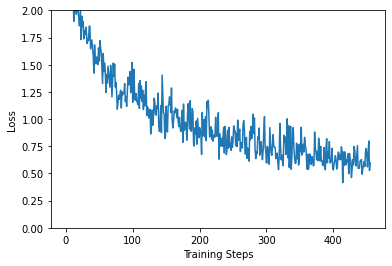

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

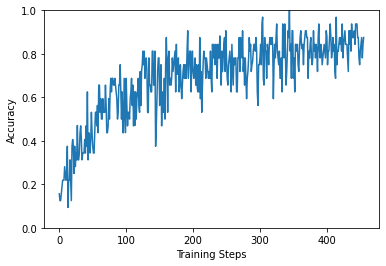

In [ ]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions

In [ ]:
class_names = sorted(test_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Captain', 'Charlie', 'Idris', 'Kim', 'Mbj', 'Rachel', 'Scar',
       'Taraji', 'Thor', 'Zendaya'], dtype='<U7')

Run the image batch through the model and convert the indices to class names.

In [ ]:
predicted_batch = model.predict(test_image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

**Plotting predictions**

In [ ]:
label_id = np.argmax(label_batch, axis=-1)

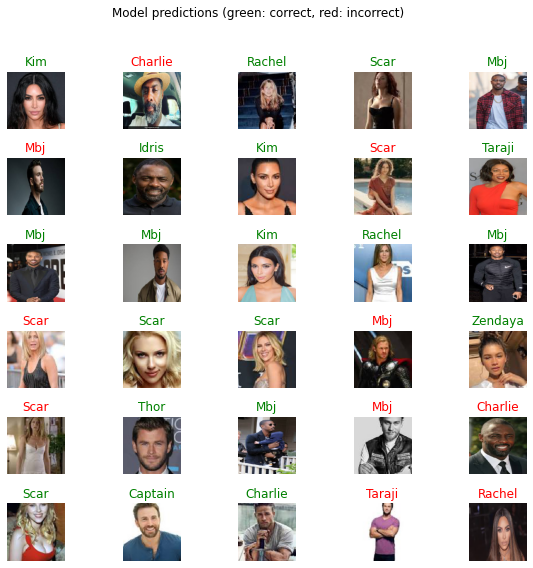

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(test_image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Random Image Predictions

65536/62825 [===============================] - 0s 0us/step


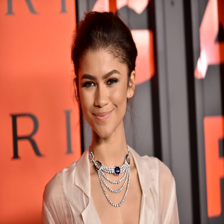

In [ ]:
test_human = tf.keras.utils.get_file('image.jpg','https://www.cheatsheet.com/wp-content/uploads/2020/02/Zendaya-2-1024x682.jpg')
test_human = Image.open(test_human).resize(IMAGE_SHAPE)
test_human

In [ ]:
# convert img to np array
test_human = np.array(test_human)/255.0
test_human.shape
# call model to make prediction
result = model.predict(test_human[np.newaxis, ...])
predicted_class = np.argmax(result[0], axis=-1)
# predicted_class
predicted_class_name = class_names[predicted_class]
# predicted_class_name

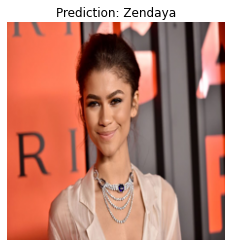

In [ ]:
plt.imshow(test_human)
plt.axis('off')
predicted_class_name = class_names[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

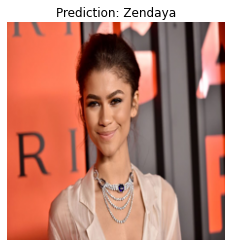

In [ ]:
xTest = tf.keras.utils.get_file('image.jpg','https://gamespot1.cbsistatic.com/uploads/scale_landscape/313/3136061/3677918-chrisevans.jpg')

def printPrediction(xTest):
  xTest = Image.open(xTest).resize(IMAGE_SHAPE)
  # convert img to np array
  xTest = np.array(xTest)/255.0
  xTest.shape
  # call model to make prediction
  result = model.predict(xTest[np.newaxis, ...])
  predicted_class = np.argmax(result[0], axis=-1)
  # predicted_class
  predicted_class_name = class_names[predicted_class]
  # predicted_class_name
  plt.imshow(xTest)
  plt.axis('off')
  predicted_class_name = class_names[predicted_class]
  _ = plt.title("Prediction: " + predicted_class_name.title())

printPrediction(xTest)

## Export model

In [ ]:
import time
t = time.time()

export_path = "/content/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /content/saved_models/1597422500/assets


INFO:tensorflow:Assets written to: /content/saved_models/1597422500/assets


'/content/saved_models/1597422500'

Export model to Gdrive

In [ ]:
t = time.time()

export_path = "/content/drive/My Drive/Models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: /content/drive/My Drive/Models/1597429966/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Models/1597429966/assets


'/content/drive/My Drive/Models/1597429966'

Now confirm that we can reload it, and it still gives the same results:

In [ ]:
reloaded = tf.keras.models.load_model(export_path)

In [ ]:
result_batch = model.predict(test_image_batch)
reloaded_result_batch = reloaded.predict(test_image_batch)

In [ ]:
abs(reloaded_result_batch - result_batch).max()

0.0

This saved model can be loaded for inference later, or converted to [TFLite](https://www.tensorflow.org/lite/convert/) or [TFjs](https://github.com/tensorflow/tfjs-converter).


# Convert to TFLite && quantize the model

No quantization

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_no_quant_tflite = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp3en6rzf7/assets


INFO:tensorflow:Assets written to: /tmp/tmp3en6rzf7/assets


In [ ]:
# # Save the model to disk
f=open('/content/drive/My Drive/Models/TFL/model_no_quant_tflite', "wb")
f.write(model_no_quant_tflite)

13527920

Dynamic range quanitization

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
model_dynamic_quant_tflite = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp33azbqiv/assets


INFO:tensorflow:Assets written to: /tmp/tmp33azbqiv/assets


In [ ]:
# # Save the model to disk
f=open('/content/drive/My Drive/Models/TFL/model_dynamic_quant_tflite', "wb")
f.write(model_dynamic_quant_tflite)

3521136

Full integer Quantization

In [ ]:
# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(500):
    yield([train_data[i].reshape(1, 1)])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce full-int8 quantization (except inputs/outputs which are always float)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

# Compre Model sizes

In [ ]:
import os
model_no_quant_size = os.path.getsize('/content/drive/My Drive/Models/TFL/model_no_quant_tflite')
print("Model is %d bytes" % model_no_quant_size)
model_dynamic_quant_size = os.path.getsize('/content/drive/My Drive/Models/TFL/model_dynamic_quant_tflite')
print("Quantized model is %d bytes" % model_dynamic_quant_size)
difference = model_no_quant_size - model_dynamic_quant_size
print("Difference is %d bytes" % difference)

Model is 13527920 bytes
Quantized model is 3521136 bytes
Difference is 10006784 bytes
